# Cleverhans ElasticNet

In [1]:
import os

os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [2]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.3
set_session(tf.Session(config=config))

Using TensorFlow backend.


In [3]:
#import libs
import numpy
import matplotlib.pyplot as plt
%matplotlib inline

from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras.optimizers import *
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from keras.models import load_model
import tensorflow as tf
import os
import numpy as np
from keras import backend

from cleverhans.attacks import FastGradientMethod
from cleverhans.attacks import ElasticNetMethod
from cleverhans.utils_keras import KerasModelWrapper

K.set_image_dim_ordering('th')

In [4]:
#data loading and preprocessing
(x_train,y_train),(x_test,y_test)=mnist.load_data()
x_train = x_train.reshape(x_train.shape[0],1,28,28).astype("float32")
x_test = x_test.reshape(x_test.shape[0],1,28,28).astype("float32")
x_train = x_train/255
x_test = x_test/255
y_test = np_utils.to_categorical(y_test)
y_train = np_utils.to_categorical(y_train)


In [5]:
#loading already trained model
# os.chdir("D:\SEMESTER1(ASSIGNMENTS)\MLCS\Project2")
#os.getcwd()
model = load_model('CNN_model.h5')


In [6]:
#making predictions and testing the accuracy of pre-trained model using test data
pred = np.argmax(model.predict(x_test), axis = 1)
new_ytest = np.argmax(y_test, axis=1)
#new_ytest.reshape(10000,10)
acc =  np.mean(np.equal(pred,new_ytest))
print("The training accuracy is: {}".format(acc*100))


The training accuracy is: 99.33


In [15]:
#new_inputs = np.array(x_test).reshape(10,28,28,1)
sub_xtest=x_test#[:1000]
sub_ytest=y_test#[:1000]
#new_test=np.array(new_test,dtype=object)
#new_test=new_test.reshape(10,28,28,1)

In [17]:
#loading ElasticNetMethod from Cleverhans and generating adverserial examples
sess =  backend.get_session()

wrap = KerasModelWrapper(model)
en = ElasticNetMethod(wrap, sess=sess)
en_params = {"beta":0.01, 
              "decision_rule":'L1',
              "batch_size":1000, 
              "confidence":0, 
              "learning_rate":0.1, 
              "binary_search_steps":9,
              "max_iterations":10,
              "abort_early":True, 
              "initial_const":0.01, 
              "clip_min":0, 
              "clip_max":1}
adv_x = en.generate_np(sub_xtest, **en_params)

[INFO 2018-11-30 23:52:54,230 cleverhans] Constructing new graph for attack ElasticNetMethod


In [19]:
#checking the accuracy of the generated adverserial examples 
adv_conf = model.predict(adv_x)
adv_pred = np.argmax(adv_conf, axis = 1)
adv_acc =  np.mean(np.equal(adv_pred,np.argmax(sub_ytest, axis=1)))


print("After attack, the accuracy is: {}".format(adv_acc*100))

After attack, the accuracy is: 0.61


In [20]:
dec_acc = ((acc - adv_acc)/acc)*100
print("Generated {} ElasticNetMethod MNIST images and the pertubations decrease the accuracy of the model by: {:.2f}%"\
      .format(len(adv_x), dec_acc))


Generated 10000 ElasticNetMethod MNIST images and the pertubations decrease the accuracy of the model by: 99.39%


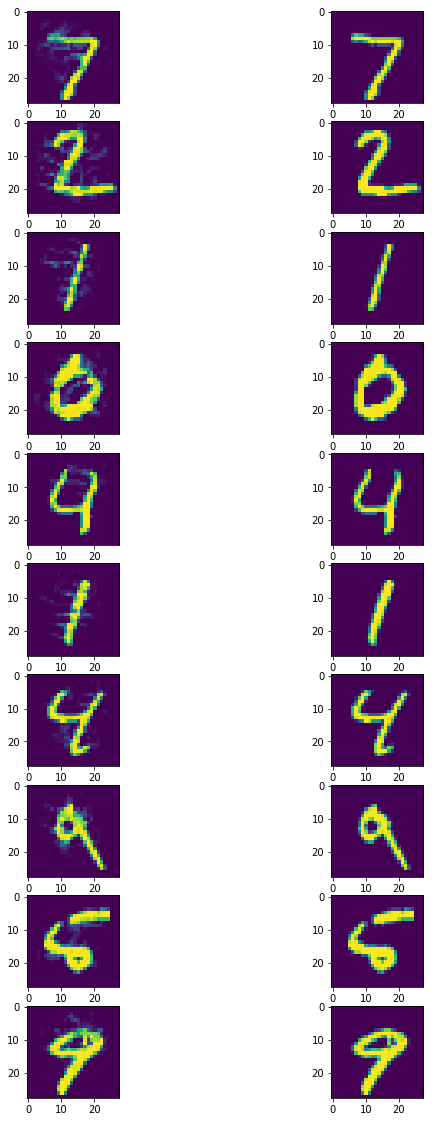

In [21]:
# comapring the first 10 original and generated images
columns = 1
rows = 10

fig,ax = plt.subplots(nrows=rows,ncols=columns*2,figsize=(10,20))

for i in range(columns*rows):
    #fig.add_subplot(rows, columns, i)
#     plt.matshow(adv_x[i-1][0])
    ax[i][0].imshow(adv_x[i][0])
   # fig.add_subplot(rows, columns, i)
#     plt.matshow(x_test[i-1][0])
    ax[i][1].imshow(x_test[i][0])
plt.show()

## Tried targeted attack on the Model : {Probably, didnt work well because of less iterations ; any other observation}

In [23]:
sess =  backend.get_session()

wrap = KerasModelWrapper(model)
target_en = ElasticNetMethod(wrap, sess=sess)
target_en_params = {"beta":0.01, 
              "decision_rule":'L1',
              "batch_size":1, 
              "confidence":0, 
              "learning_rate":0.1, 
              "binary_search_steps":9,
              "max_iterations":10,
              "abort_early":False, 
              "initial_const":0.01, 
              "clip_min":0,"y_target":[0,0,0,0,0,1,0,0,0,0],
                 
              "clip_max":1}
t_adv_x = target_en.generate_np(sub_xtest, **en_params)

[INFO 2018-11-29 17:33:05,952 cleverhans] Constructing new graph for attack ElasticNetMethod


In [24]:
t_adv_conf = model.predict(t_adv_x)
t_adv_pred = np.argmax(t_adv_conf, axis = 1)
t_adv_acc =  np.mean(np.equal(t_adv_pred,sub_ytest))


print("After attack, the accuracy is: {}".format(t_adv_acc*100))

After attack, the accuracy is: 2.0


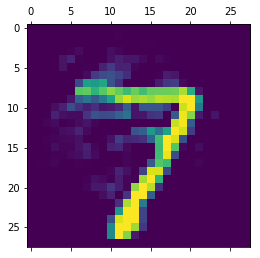

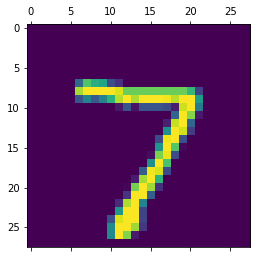

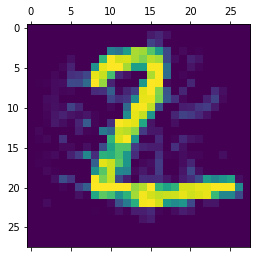

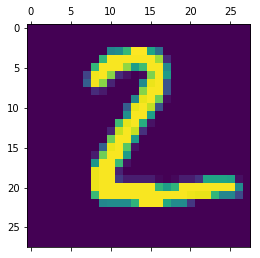

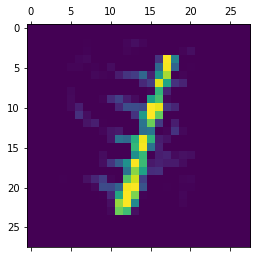

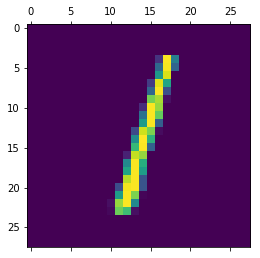

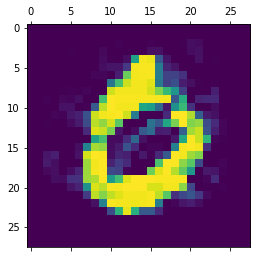

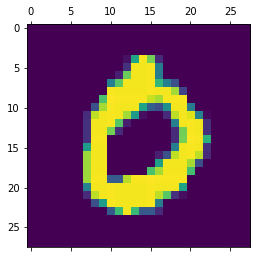

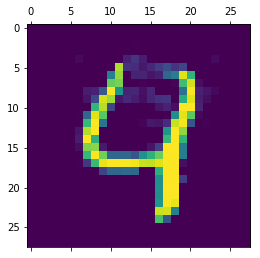

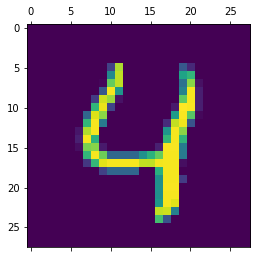

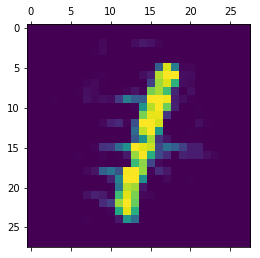

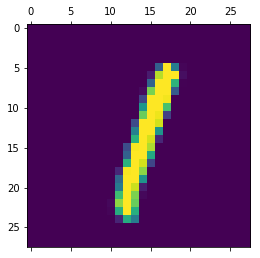

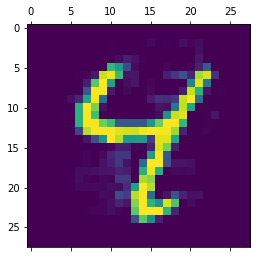

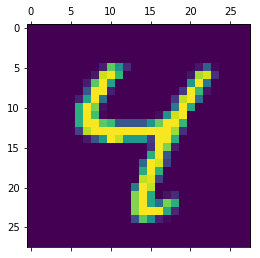

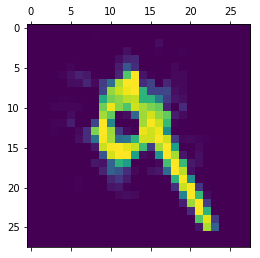

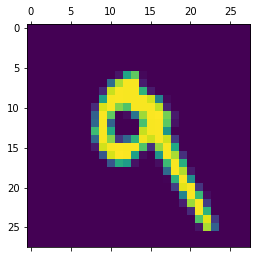

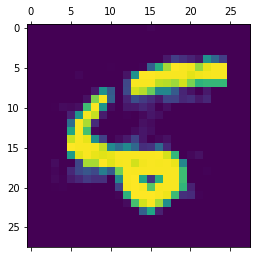

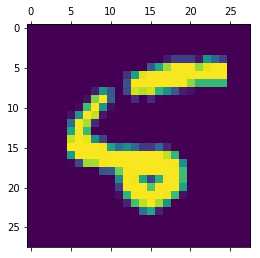

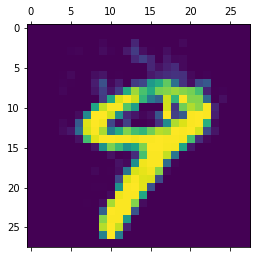

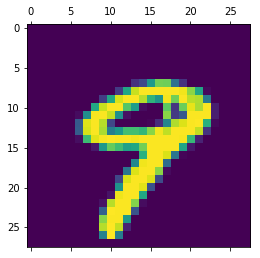

In [26]:
columns = 1
rows = 10
for i in range(1, columns*rows +1):
    #fig.add_subplot(rows, columns, i)
    plt.matshow(t_adv_x[i-1][0])
    #fig.add_subplot(rows, columns, i)
    plt.matshow(x_test[i-1][0])
plt.show()